In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
from keras.utils.np_utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [3]:
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
sample = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
train.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB


In [8]:
X = train.copy()
y = X.pop("label")
X = X/255
y = to_categorical(y, 10)

In [9]:
"""
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, train.pop("label"))
mi_scores[::3]  # show a few features with their MI scores


mi_scores.describe()


mi_scores.plot() #Seems to be three distinct sets of pixels from the graph. 
"""

'\nfrom sklearn.feature_selection import mutual_info_classif\n\ndef make_mi_scores(X, y):\n    mi_scores = mutual_info_classif(X, y)\n    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)\n    mi_scores = mi_scores.sort_values(ascending=False)\n    return mi_scores\n\nmi_scores = make_mi_scores(X, train.pop("label"))\nmi_scores[::3]  # show a few features with their MI scores\n\n\nmi_scores.describe()\n\n\nmi_scores.plot() #Seems to be three distinct sets of pixels from the graph. \n'

In [10]:
X_train = X[:35000]
X_valid = X[35000:]
y_train = y[:35000]
y_valid = y[35000:]

2022-01-28 23:57:43.155616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 23:57:43.254237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 23:57:43.255007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-28 23:57:43.256319: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/10
7/7 [==============================] - 2s 86ms/step - loss: 1.2677 - categorical_accuracy: 0.6849 - val_loss: 0.4863 - val_categorical_accuracy: 0.8344
Epoch 2/10
7/7 [==============================] - 0s 34ms/step - loss: 0.4364 - categorical_accuracy: 0.8628 - val_loss: 0.3421 - val_categorical_accuracy: 0.8984
Epoch 3/10
7/7 [==============================] - 0s 31ms/step - loss: 0.3056 - categorical_accuracy: 0.9101 - val_loss: 0.2532 - val_categorical_accuracy: 0.9236
Epoch 4/10
7/7 [==============================] - 0s 29ms/step - loss: 0.2321 - categorical_accuracy: 0.9313 - val_loss: 0.2066 - val_categorical_accuracy: 0.9384
Epoch 5/10
7/7 [==============================] - 0s 29ms/step - loss: 0.1855 - categorical_accuracy: 0.9459 - val_loss: 0.1795 - val_categorical_accuracy: 0.9471
Epoch 6/10
7/7 [==============================] - 0s 31ms/step - loss: 0.1549 - categorical_accuracy: 0.9546 - val_loss: 0.1597 - val_categorical_accuracy: 0.9529
Epoch 7/10
7/7 [======

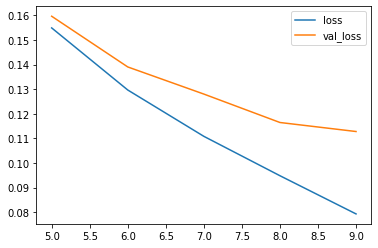

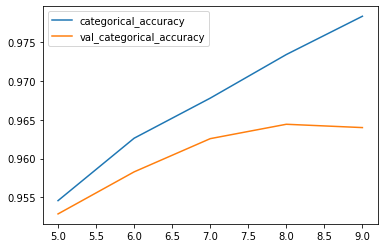

In [11]:
#First attempt, basic model with 3 hidden layers.

model1 = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[784]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],

)

history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=5000,
    epochs=10,
)

history1_df = pd.DataFrame(history1.history)
# Start the plot at epoch 5
history1_df.loc[5:, ['loss', 'val_loss']].plot()
history1_df.loc[5:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history1_df['val_loss'].min(), 
              history1_df['val_categorical_accuracy'].max()))

pred1 = model1.predict(test).argmax(axis=-1)
pred1 = pred1.tolist()

final1 = sample.copy()
final1["Label"] = pred1
final1.to_csv("sub1", index=False) #092567

Epoch 1/20
7/7 [==============================] - 1s 77ms/step - loss: 1.3099 - categorical_accuracy: 0.6617 - val_loss: 0.5351 - val_categorical_accuracy: 0.8211
Epoch 2/20
7/7 [==============================] - 0s 32ms/step - loss: 0.4281 - categorical_accuracy: 0.8673 - val_loss: 0.3288 - val_categorical_accuracy: 0.9041
Epoch 3/20
7/7 [==============================] - 0s 30ms/step - loss: 0.3031 - categorical_accuracy: 0.9127 - val_loss: 0.2560 - val_categorical_accuracy: 0.9257
Epoch 4/20
7/7 [==============================] - 0s 30ms/step - loss: 0.2313 - categorical_accuracy: 0.9323 - val_loss: 0.2072 - val_categorical_accuracy: 0.9404
Epoch 5/20
7/7 [==============================] - 0s 29ms/step - loss: 0.1844 - categorical_accuracy: 0.9462 - val_loss: 0.1764 - val_categorical_accuracy: 0.9483
Epoch 6/20
7/7 [==============================] - 0s 29ms/step - loss: 0.1510 - categorical_accuracy: 0.9561 - val_loss: 0.1544 - val_categorical_accuracy: 0.9569
Epoch 7/20
7/7 [======

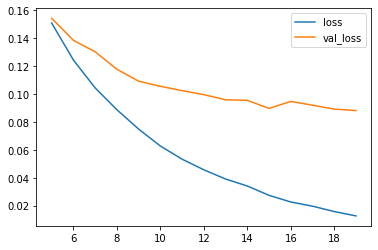

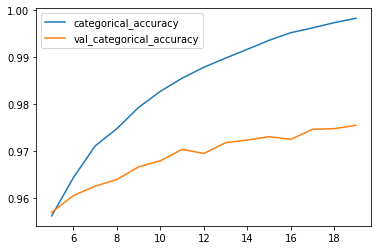

In [12]:
#From the graphs, seems like we could benefit from running more epochs, so let's try that: 

model2 = keras.Sequential([
    layers.Dense(1024, activation='relu', input_shape=[784]),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],

)

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=5000,
    epochs=20,
)

history2_df = pd.DataFrame(history2.history)
# Start the plot at epoch 5
history2_df.loc[5:, ['loss', 'val_loss']].plot()
history2_df.loc[5:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history2_df['val_loss'].min(), 
              history2_df['val_categorical_accuracy'].max()))

Epoch 1/20
7/7 [==============================] - 1s 72ms/step - loss: 1.2064 - categorical_accuracy: 0.6535 - val_loss: 0.6746 - val_categorical_accuracy: 0.7727
Epoch 2/20
7/7 [==============================] - 0s 34ms/step - loss: 0.4778 - categorical_accuracy: 0.8508 - val_loss: 0.3565 - val_categorical_accuracy: 0.8836
Epoch 3/20
7/7 [==============================] - 0s 34ms/step - loss: 0.2983 - categorical_accuracy: 0.9126 - val_loss: 0.2409 - val_categorical_accuracy: 0.9304
Epoch 4/20
7/7 [==============================] - 0s 33ms/step - loss: 0.2185 - categorical_accuracy: 0.9342 - val_loss: 0.1870 - val_categorical_accuracy: 0.9456
Epoch 5/20
7/7 [==============================] - 0s 36ms/step - loss: 0.1700 - categorical_accuracy: 0.9509 - val_loss: 0.1595 - val_categorical_accuracy: 0.9541
Epoch 6/20
7/7 [==============================] - 0s 33ms/step - loss: 0.1354 - categorical_accuracy: 0.9589 - val_loss: 0.1388 - val_categorical_accuracy: 0.9594
Epoch 7/20
7/7 [======

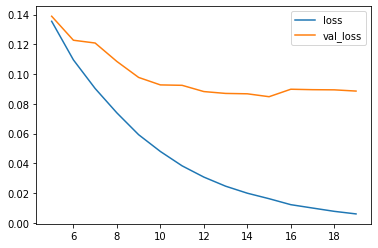

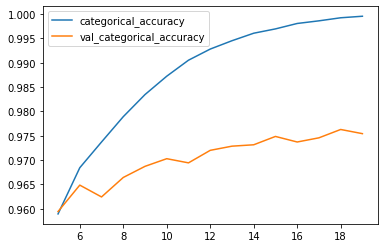

In [13]:
#Let's try changing the number of nodes in the hidden layers: 

model3 = keras.Sequential([
    layers.Dense(1000, activation='relu', input_shape=[784]),
    layers.Dense(1000, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],

)

history3 = model3.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=5000,
    epochs=20,
)

history3_df = pd.DataFrame(history3.history)
# Start the plot at epoch 5
history3_df.loc[5:, ['loss', 'val_loss']].plot()
history3_df.loc[5:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history3_df['val_loss'].min(), 
              history3_df['val_categorical_accuracy'].max()))

#Seems to be better, but may be overfit. Let's see how it does with the test set: 

pred3 = model3.predict(test).argmax(axis=-1)
pred3 = pred3.tolist()
final3 = sample.copy()
final3["Label"] = pred3
final3.to_csv("sub3", index=False) #0.94903, best so far.

Epoch 1/20
7/7 [==============================] - 1s 73ms/step - loss: 1.7271 - categorical_accuracy: 0.5108 - val_loss: 0.7740 - val_categorical_accuracy: 0.7663
Epoch 2/20
7/7 [==============================] - 0s 29ms/step - loss: 0.7372 - categorical_accuracy: 0.7633 - val_loss: 0.4970 - val_categorical_accuracy: 0.8377
Epoch 3/20
7/7 [==============================] - 0s 26ms/step - loss: 0.4491 - categorical_accuracy: 0.8567 - val_loss: 0.3904 - val_categorical_accuracy: 0.8809
Epoch 4/20
7/7 [==============================] - 0s 29ms/step - loss: 0.3258 - categorical_accuracy: 0.9024 - val_loss: 0.2797 - val_categorical_accuracy: 0.9164
Epoch 5/20
7/7 [==============================] - 0s 28ms/step - loss: 0.2526 - categorical_accuracy: 0.9230 - val_loss: 0.2268 - val_categorical_accuracy: 0.9321
Epoch 6/20
7/7 [==============================] - 0s 27ms/step - loss: 0.2017 - categorical_accuracy: 0.9384 - val_loss: 0.1874 - val_categorical_accuracy: 0.9444
Epoch 7/20
7/7 [======

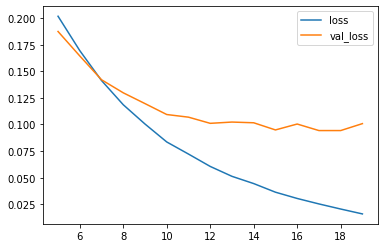

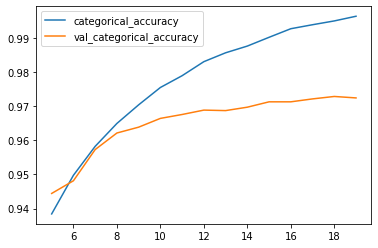

In [14]:
#Let's try using 6 hidden layers and see what difference that makes. We'll use less nodes per layer.  

#POST: Took significantly less time to train compared to previous model and had the same performance on the validation set.

model4 = keras.Sequential([
    layers.Dense(700, activation='relu', input_shape=[784]),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'],

)

history4 = model4.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=5000,
    epochs=20,
)

history4_df = pd.DataFrame(history4.history)
# Start the plot at epoch 5
history4_df.loc[5:, ['loss', 'val_loss']].plot()
history4_df.loc[5:, ['categorical_accuracy', 'val_categorical_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history4_df['val_loss'].min(), 
              history4_df['val_categorical_accuracy'].max()))

pred4 = model4.predict(test).argmax(axis=-1)
pred4 = pred4.tolist()
final4 = sample.copy()
final4["Label"] = pred4
final4.to_csv("sub4", index=False) #0.95417, best so far. Seems like more layers with less nodes works better.

In [15]:
"""
Now we will make a more complicated CNN model using convolutional layers as well as some other layers to improve model 
performance. We will include all of this in a function so that it is easier to recall and adjust.
"""

X_2D = train.copy()
y_2D = X_2D.pop("label")
y_2D = to_categorical(y_2D, num_classes = 10)
X_2D = X_2D/255 #Normalisation
X_2D = X_2D.values.reshape(-1,28,28,1)

test_2D = test.copy()
test_2D = test_2D/255 #Normalisation
test_2D = test_2D.values.reshape(-1,28,28,1)

X_train_2D = X_2D[:35000]
X_valid_2D = X_2D[35000:]
y_train_2D = y_2D[:35000]
y_valid_2D = y_2D[35000:]

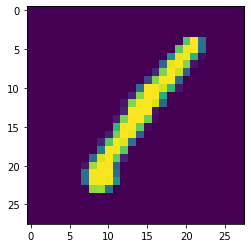

In [16]:
%matplotlib inline
plt.imshow(X_train_2D[0][:,:,0])

In [17]:
#Let's write a function that does all of the model building, training and validation and allows us to change the number
#of dense layers easily.

def model(n: int, v: list, b: int, e: int):
    
    """
    Returns the trained NN for the digit recognition problem. The variables are: number of hidden layers, a list of length
    n giving the number of nodes per layer, the batch number and the number of epochs.
    """
    
    model = keras.Sequential()
    model.add(Conv2D(32, (5,5), input_shape=(28,28,1), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2) ))
    model.add(Dropout(0.2))
    model.add(Flatten())
    #Now we add n hidden layers, with number of nodes determined by v.
    for i in range(0,n):
        model.add(layers.Dense(v[i], activation='relu'))
    
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )
    
    history = model.fit(
    X_train_2D, y_train_2D,
    validation_data=(X_valid_2D, y_valid_2D),
    batch_size=b,
    epochs=e,
    )
    
    history_df = pd.DataFrame(history.history)
    # Start the plot at epoch 5
    history_df.loc[5:, ['loss', 'val_loss']].plot()
    history_df.loc[5:, ['accuracy', 'val_accuracy']].plot()

    print(("Best Validation Loss: {:0.4f}" +\
          "\nBest Validation Accuracy: {:0.4f}")\
          .format(history_df['val_loss'].min(), 
                  history_df['val_accuracy'].max()))
    
    return model


def submission(model, test):
    """
    Given a trained model and test data, outputs the results as a dataframe.
    """
    pred = model.predict(test).argmax(axis=-1)
    pred = pred.tolist()
    sub = sample.copy()
    sub["Label"] = pred
    return sub

Epoch 1/30


2022-01-28 23:58:18.022417: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


70/70 [==============================] - 6s 10ms/step - loss: 0.5044 - accuracy: 0.8405 - val_loss: 0.1626 - val_accuracy: 0.9496
Epoch 2/30
70/70 [==============================] - 1s 7ms/step - loss: 0.1057 - accuracy: 0.9671 - val_loss: 0.0833 - val_accuracy: 0.9751
Epoch 3/30
70/70 [==============================] - 1s 7ms/step - loss: 0.0611 - accuracy: 0.9810 - val_loss: 0.0580 - val_accuracy: 0.9829
Epoch 4/30
70/70 [==============================] - 1s 7ms/step - loss: 0.0437 - accuracy: 0.9862 - val_loss: 0.0679 - val_accuracy: 0.9796
Epoch 5/30
70/70 [==============================] - 1s 8ms/step - loss: 0.0319 - accuracy: 0.9904 - val_loss: 0.0585 - val_accuracy: 0.9821
Epoch 6/30
70/70 [==============================] - 1s 9ms/step - loss: 0.0235 - accuracy: 0.9921 - val_loss: 0.0631 - val_accuracy: 0.9817
Epoch 7/30
70/70 [==============================] - 1s 8ms/step - loss: 0.0220 - accuracy: 0.9926 - val_loss: 0.0471 - val_accuracy: 0.9869
Epoch 8/30
70/70 [============

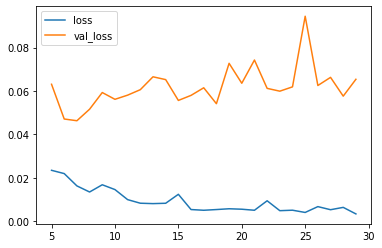

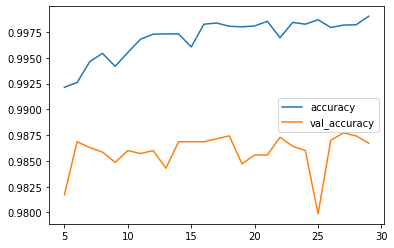

In [18]:
model5 = model(6, [600, 500, 400, 300,200,100], 500, 30)

In [19]:
submission(model5, test_2D).to_csv("sub5", index=False) #0.98453, much better than simple models above. 
#To improve further, we could try augmenting the data to reduce overfitting problems...